In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import random
import re
from validation_functions import *
from numba import njit

# plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 22
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

In [2]:
def read_inf_coords(dim, path):
    df = pd.read_csv(path, sep="\s+", header=None, comment="#")
    if dim == 1:
        df.columns = ['index', 'inf_kappa', 'inf_theta', 'inf_radius']
    else:
        cols = [f'inf_p{i}' for i in range(dim+1)]
        df.columns = ['index', 'inf_kappa', 'inf_radius', *cols] # TODO: test it
    return df


def read_all_coordinates(dim ,folder):
    inf_coord_files = glob.glob(f'{folder}/*inf_coord*')
    for file in inf_coord_files:
        if 'features_le' in file:
            inf_coord_features_le = read_inf_coords(dim, file)
        elif 'nodes_le' in file:
            inf_coord_nodes_le = read_inf_coords(dim, file)
        elif 'features' in file:
            inf_coord_features = read_inf_coords(dim, file)
        elif 'nodes' in file:
            inf_coord_nodes = read_inf_coords(dim, file)
        elif '_raw' in file:
            ''
        elif 'coord_le' in file:
            inf_coord_le = read_inf_coords(dim, file)
        else:
            inf_coord = read_inf_coords(dim, file)
        
    # Merge inferred and generated coordinates
    # 1. Coordinates of nodes in bipartite
    # 2. Coordinates of features in bipartite
    df_nodes = inf_coord_nodes.merge(inf_coord_nodes_le, on='index', suffixes=('', '_le'))
    df_features = inf_coord_features.merge(inf_coord_features_le, on='index', suffixes=('', '_le'))
    return df_nodes, df_features

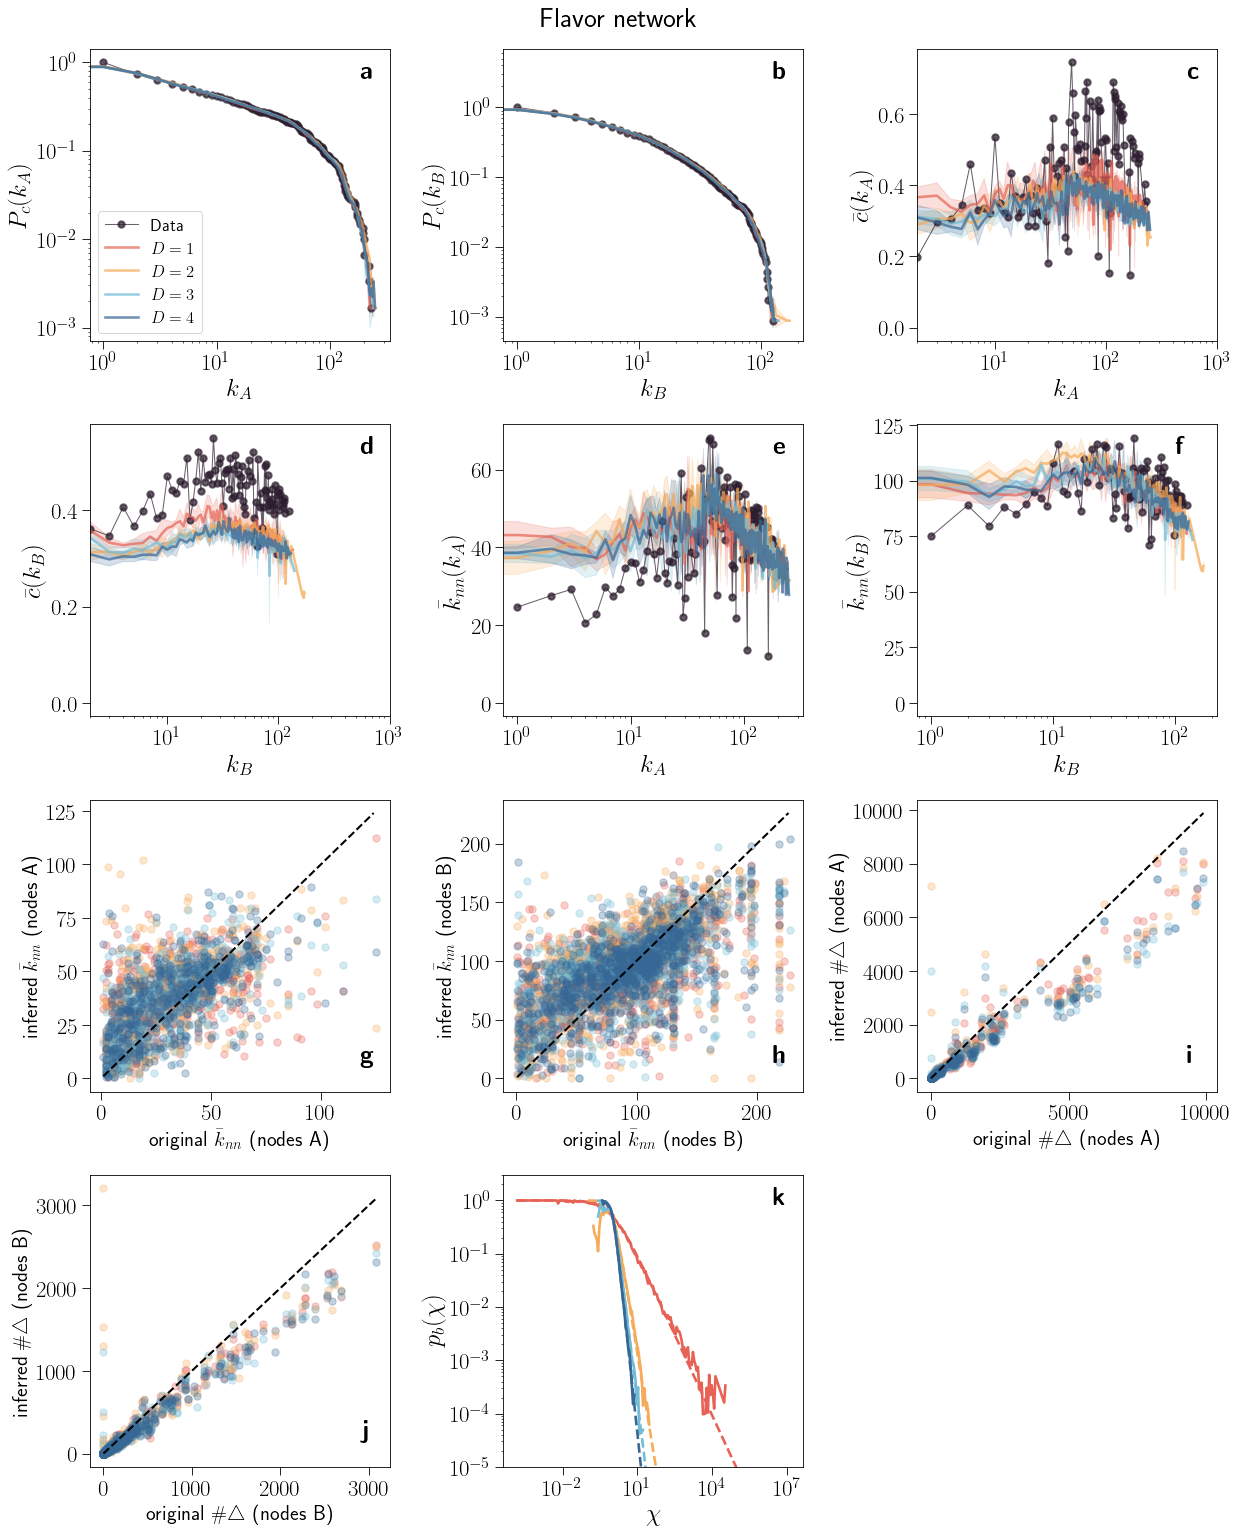

In [3]:
base_path = "/home/rob/MEGAsync/datasets/networks/bipartite_networks/flavor_network/Flavor-Network/data/"

filename = 'ingr_comp'

paths = [f"{base_path}/eS{d}" for d in [1, 2, 3, 4]]
labels = [rf'$D={d}$' for d in [1, 2, 3, 4]]


# Bipartite
dfs_vstats_bipartite_nodes = [load_vstats_bipartite_nodes(p, filename) for p in paths]
dfs_vstats_bipartite_features = [load_vstats_bipartite_features(p, filename) for p in paths]

df_vprop_bipartite_nodes = [load_vprops_bipartite_nodes(p, filename) for p in paths]
df_vprop_bipartite_features = [load_vprops_bipartite_features(p, filename) for p in paths]

df_obs_bipartite_nodes = load_vstat_obs_bipartite_nodes(paths[0], filename)
df_obs_bipartite_features = load_vstat_obs_bipartite_features(paths[0], filename)
df_pconns_bipartite = [load_bipartite_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(17, 21))
plt.subplot(4, 3, 1)
plot_degree_distribution(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels, xlabel=r'$k_A$',
                         ylabel=r'$P_c(k_A)$')
plt.legend(loc='lower left', fontsize=16)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 2)
plot_degree_distribution(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels, xlabel=r'$k_B$',
                         ylabel=r'$P_c(k_B)$')
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 3)
plot_clustering_coefficient(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels, xlabel=r'$k_A$',
                         ylabel=r'$\bar{c}(k_A)$')
plt.xlim(2, 1000)
plt.text(0.9, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 4)
plot_clustering_coefficient(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels, xlabel=r'$k_B$',
                         ylabel=r'$\bar{c}(k_B)$')
plt.xlim(2, 1000)
plt.text(0.9, 0.9, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 5)
plot_average_degree_neighbour(df_obs_bipartite_nodes, dfs_vstats_bipartite_nodes, labels,
                              xlabel=r'$k_A$', ylabel=r"$\bar{k}_{nn}(k_A)$")
plt.text(0.9, 0.9, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 6)
plot_average_degree_neighbour(df_obs_bipartite_features, dfs_vstats_bipartite_features, labels,
                              xlabel=r'$k_B$', ylabel=r"$\bar{k}_{nn}(k_B)$")
plt.text(0.86, 0.9, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 7)
plot_sum_degree_neighbours(df_vprop_bipartite_nodes, labels, additional_label=' (nodes A)', 
                           log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{g}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 8)
plot_sum_degree_neighbours(df_vprop_bipartite_features, labels, additional_label=' (nodes B)',
                           log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{h}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 9)
plot_number_of_triangles(df_vprop_bipartite_nodes, labels, additional_label=' (nodes A)', 
                         log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{i}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 10)
plot_number_of_triangles(df_vprop_bipartite_features, labels, additional_label=' (nodes B)', 
                         log_scale=False)
plt.text(0.9, 0.1, r'$\textbf{j}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(4, 3, 11)
plot_connection_probabilities(df_pconns_bipartite, labels, ylabel=r'$p_b(\chi)$')
plt.text(0.9, 0.9, r'$\textbf{k}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'Flavor network', y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/flavor_validation.pdf")

In [4]:
p = "/home/rob/MEGAsync/datasets/networks/bipartite_networks/flavor_network/Flavor-Network/data/"

df_nodes_S1, df_features_S1 = read_all_coordinates(1, f"{p}/eS1")
df_nodes_S2, df_features_S2 = read_all_coordinates(2, f"{p}/eS2")
# df_nodes_S3, df_features_S3 = read_all_coordinates(3, f"{p}/eS3")
# df_nodes_S4, df_features_S4 = read_all_coordinates(4, f"{p}/eS4")

In [5]:
df_nodes_S1.shape, df_features_S1.shape

((602, 7), (1138, 7))

In [6]:
category_color_mapping = {
    'flower': '#FFB6C1',  # Light Pink
    'plant': '#228B22',  # Green
    'plant derivative': '#808000',  # Olive
    'fish/seafood': '#ADD8E6',  # Light Blue
    'herb': '#006400',  # Dark Green
    'spice': '#FFA500',  # Orange
    'vegetable': '#556B2F',  # Dark Olive Green
    'nut/seed/pulse': '#8B4513',  # Brown
    'meat': '#FF4500',  # Red
    'fruit': '#FFD700',  # Yellow
    'animal product': '#D2B48C',  # Light Brown
    'cereal/crop': '#DAA520',  # Goldenrod
    'dairy': '#FFFACD',  # Light Yellow
    'alcoholic beverage': '#800080'  # Purple
}

df_ingr_labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/bipartite_networks/flavor_network/Flavor-Network/data/ingr_info.tsv", sep="\t")
df_ingr_labels.columns = ['index', 'ingredient', 'category']
df_ingr_labels['color'] = df_ingr_labels['category'].map(category_color_mapping)
df_ingr_labels.head()

,index,ingredient,category,color
0,0,magnolia_tripetala,flower,#FFB6C1
1,1,calyptranthes_parriculata,plant,#228B22
2,2,chamaecyparis_pisifera_oil,plant derivative,#808000
3,3,mackerel,fish/seafood,#ADD8E6
4,4,mimusops_elengi_flower,flower,#FFB6C1


In [7]:
df_ingr_labels.shape

(1530, 4)

In [8]:
df_ingr_labels['category'].unique()

array(['flower', 'plant', 'plant derivative', 'fish/seafood', 'herb',
       'spice', 'vegetable', 'nut/seed/pulse', 'meat', 'fruit',
       'animal product', 'cereal/crop', 'dairy', 'alcoholic beverage'],
      dtype=object)

In [9]:
df_comp_labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/bipartite_networks/flavor_network/Flavor-Network/data/comp_info.tsv", sep="\t")
df_comp_labels.columns = ['index', 'compound_name', 'CAS_number']
df_comp_labels.head()

,index,compound_name,CAS_number
0,0,jasmone,488-10-8
1,1,5-methylhexanoic_acid,628-46-6
2,2,l-glutamine,56-85-9
3,3,1-methyl-3-methoxy-4-isopropylbenzene,1076-56-8
4,4,methyl-3-phenylpropionate,103-25-3


In [ ]:
df_comp_labels.shape

In [ ]:
df_comp_labels['CAS_number'].values[:10]

In [ ]:
df_features_S1 = df_features_S1.merge(df_comp_labels)
df_features_S2 = df_features_S2.merge(df_comp_labels)

df_nodes_S1 = df_nodes_S1.merge(df_ingr_labels)
df_nodes_S2 = df_nodes_S2.merge(df_ingr_labels)

In [ ]:
from matplotlib.patches import Circle

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

df_nodes_S1['x'] = df_nodes_S1['inf_radius'] * np.cos(df_nodes_S1['inf_theta'])
df_nodes_S1['y'] = df_nodes_S1['inf_radius'] * np.sin(df_nodes_S1['inf_theta'])    
axs[0].scatter(df_nodes_S1['x'], df_nodes_S1['y'], s=20*np.log(df_nodes_S1['inf_kappa'] + 1), 
               color=df_nodes_S1['color'], edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)

max_radius = df_nodes_S1['inf_radius'].max()
circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
axs[0].add_patch(circle)
axs[0].legend()

df_features_S1['x'] = df_features_S1['inf_radius'] * np.cos(df_features_S1['inf_theta'])
df_features_S1['y'] = df_features_S1['inf_radius'] * np.sin(df_features_S1['inf_theta']) 
axs[1].scatter(df_features_S1['x'], df_features_S1['y'], s=20*np.log(df_features_S1['inf_kappa'] + 1), 
               edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)


max_radius = df_features_S1['inf_radius'].max()
circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
axs[1].add_patch(circle)

axs[1].legend(fontsize=13)

axs[0].set_title(r'$\theta_n^{\mathrm{inf}}$')
axs[1].set_title(r'$\theta_f^{\mathrm{inf}}$')
axs[0].axis('off')
axs[1].axis('off')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_nodes_S2['inf_p0'], df_nodes_S2['inf_p1'], df_nodes_S2['inf_p2'], 
           s=20*np.log(df_nodes_S2['inf_kappa'] + 1), color=df_nodes_S2['color'],
           edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_features_S2['inf_p0'], df_features_S2['inf_p1'], df_features_S2['inf_p2'], 
           s=20*np.log(df_features_S2['inf_kappa'] + 1),
           edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)

In [ ]:
from networkx.algorithms import bipartite

g = bipartite.read_edgelist("/home/rob/MEGAsync/datasets/networks/bipartite_networks/flavor_network/Flavor-Network/data/eS1/ingr_comp.edge",
                           nodetype=int)
print(g)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

def plot_compound_ingredients(index, compound_name, g, df_nodes_S1, df_features_S1, max_degree=100):
    pos_x, pos_y, ingredients, categories, colors, kappas, sizes = [], [], [], [], [], [], []

    # Get the feature row for the given compound_name
    compound_row = df_features_S1[df_features_S1['compound_name'] == compound_name]
    if compound_row.empty:
        print(f"Compound '{compound_name}' not found in df_features_S1.")
        return

    compound_x = compound_row['x'].values[0]
    compound_y = compound_row['y'].values[0]

    for ingredient in list(g.neighbors(index)):
        tmp = df_nodes_S1[df_nodes_S1['index'] == ingredient]
        if len(tmp) < 1:
            continue
        pos_x.append(tmp['inf_radius'] * np.cos(tmp['inf_theta']))
        pos_y.append(tmp['inf_radius'] * np.sin(tmp['inf_theta']))
        ingredients.append(tmp['ingredient'].values[0])
        categories.append(tmp['category'].values[0])
        colors.append(tmp['color'].values[0])
        kappas.append(tmp['inf_kappa'].values[0])
        sizes.append(g.degree(ingredient))

    sizes = np.array(sizes)
    
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.scatter(pos_x, pos_y, c=colors, s=sizes, edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)

    for (x, y, ingredient, s) in zip(pos_x, pos_y, ingredients, sizes):
        if s > max_degree:
            ax.text(x, y, ingredient, fontsize=20, zorder=3)

    ax.scatter(compound_x, compound_y, s=500, color='grey', marker='*', edgecolors='black', zorder=5)
    ax.text(compound_x, compound_y, compound_name,
            color='xkcd:black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'), zorder=10)


    max_radius = df_nodes_S1['inf_radius'].max()
    circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
    ax.add_patch(circle)

    # Create a legend for categories
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
        for category, color in category_color_mapping.items() if category in categories
    ]
    legend_labels = [category for category in category_color_mapping.keys() if category in categories]
    ax.legend(legend_handles, legend_labels, loc=(1, 0.1), framealpha=1)

    ax.axis('off')
    #ax.set_title(f"{compound_name}")
    ax.set_box_aspect(1)
    plt.tight_layout()


In [ ]:
df_features_S1[df_features_S1['CAS_number'] == '121-33-5']

In [ ]:
plot_compound_ingredients(index=419,
                          compound_name='ethyl_alcohol',
                          g=g, 
                          df_nodes_S1=df_nodes_S1, 
                          df_features_S1=df_features_S1,
                          max_degree=100)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S1_compound_ethyl_alcohol.pdf")

In [ ]:
plot_compound_ingredients(index=939,
                          compound_name='glycerol',
                          g=g, 
                          df_nodes_S1=df_nodes_S1, 
                          df_features_S1=df_features_S1,
                          max_degree=150)


# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S1_compound_glycerol.pdf")

In [ ]:
plot_compound_ingredients(index=565,
                          compound_name='caffeine',
                          g=g, 
                          df_nodes_S1=df_nodes_S1, 
                          df_features_S1=df_features_S1,
                          max_degree=1)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S1_compound_caffeine.pdf")

In [ ]:
plot_compound_ingredients(index=467,
                          compound_name='citric_acid',
                          g=g, 
                          df_nodes_S1=df_nodes_S1, 
                          df_features_S1=df_features_S1,
                          max_degree=1)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S1_compound_citric_acid.pdf")

In [ ]:
plot_compound_ingredients(index=249,
                          compound_name='pyridine',
                          g=g, 
                          df_nodes_S1=df_nodes_S1, 
                          df_features_S1=df_features_S1,
                          max_degree=150)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S1_compound_pyridine.pdf")

In [ ]:
plot_compound_ingredients(index=602,
                          compound_name='eucalyptol',
                          g=g, 
                          df_nodes_S1=df_nodes_S1, 
                          df_features_S1=df_features_S1,
                          max_degree=70)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S1_compound_eucalyptol.pdf")

In [ ]:
plot_compound_ingredients(index=423,
                          compound_name='vanillin',
                          g=g, 
                          df_nodes_S1=df_nodes_S1, 
                          df_features_S1=df_features_S1,
                          max_degree=100)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S1_compound_vanillin.pdf")

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_compound_ingredients_sphere(index, compound_name, g, df_nodes_S1, df_features_S1, max_degree=100):
    pos_x, pos_y, pos_z = [], [], []
    ingredients, categories, colors, kappas, sizes = [], [], [], [], []

    # Get the feature row for the given compound_name
    compound_row = df_features_S1[df_features_S1['compound_name'] == compound_name]
    if compound_row.empty:
        print(f"Compound '{compound_name}' not found in df_features_S1.")
        return

    # Extract the 3D coordinates for the compound
    compound_x = compound_row['inf_p0'].values[0]
    compound_y = compound_row['inf_p1'].values[0]
    compound_z = compound_row['inf_p2'].values[0]

    # Iterate over neighbors (ingredients) of the given compound index
    for ingredient in list(g.neighbors(index)):
        tmp = df_nodes_S1[df_nodes_S1['index'] == ingredient]
        if len(tmp) < 1:
            continue

        pos_x.append(tmp['inf_p0'].values[0])
        pos_y.append(tmp['inf_p1'].values[0])
        pos_z.append(tmp['inf_p2'].values[0])
        ingredients.append(tmp['ingredient'].values[0])
        categories.append(tmp['category'].values[0])
        colors.append(tmp['color'].values[0])
        kappas.append(tmp['inf_kappa'].values[0])
        sizes.append(g.degree(ingredient))

    sizes = np.array(sizes)

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for ingredients
    ax.scatter(pos_x, pos_y, pos_z, c=colors, s=sizes, edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)

    # Annotate points with ingredient names for those with high degree
    for (x, y, z, ingredient, s) in zip(pos_x, pos_y, pos_z, ingredients, sizes):
        if s > max_degree:
            ax.text(x, y, z, ingredient, fontsize=16, zorder=3)

    # Highlight the compound with a star marker
    ax.scatter(compound_x, compound_y, compound_z, s=500, color='grey', marker='*', edgecolors='black', zorder=5)

    # Plot the sphere wireframe
    max_radius = np.linalg.norm([compound_x, compound_y, compound_z])

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    sphere_x = max_radius * np.outer(np.cos(u), np.sin(v))
    sphere_y = max_radius * np.outer(np.sin(u), np.sin(v))
    sphere_z = max_radius * np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(sphere_x, sphere_y, sphere_z, color='black', linewidth=0.5, alpha=0.1)

    ax.set_title(f"{compound_name}")

    # Create a legend for categories
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
        for category, color in category_color_mapping.items() if category in categories
    ]
    legend_labels = [category for category in category_color_mapping.keys() if category in categories]
    ax.legend(legend_handles, legend_labels, loc=(1, 0.1), framealpha=1)

    # Set aspect ratio and limits
    ax.set_box_aspect([1, 1, 1])
    ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
plot_compound_ingredients_sphere(index=419,
                          compound_name='ethyl_alcohol',
                          g=g, 
                          df_nodes_S1=df_nodes_S2, 
                          df_features_S1=df_features_S2,
                          max_degree=100)

In [ ]:
plot_compound_ingredients_sphere(index=939,
                          compound_name='glycerol',
                          g=g, 
                          df_nodes_S1=df_nodes_S2, 
                          df_features_S1=df_features_S2,
                          max_degree=150)

In [ ]:
plot_compound_ingredients_sphere(index=565,
                          compound_name='caffeine',
                          g=g, 
                          df_nodes_S1=df_nodes_S2, 
                          df_features_S1=df_features_S2,
                          max_degree=1)

In [ ]:
plot_compound_ingredients_sphere(index=467,
                          compound_name='citric_acid',
                          g=g, 
                          df_nodes_S1=df_nodes_S2, 
                          df_features_S1=df_features_S2,
                          max_degree=1)

In [ ]:
plot_compound_ingredients_sphere(index=249,
                          compound_name='pyridine',
                          g=g, 
                          df_nodes_S1=df_nodes_S2, 
                          df_features_S1=df_features_S2,
                          max_degree=150)

In [ ]:
plot_compound_ingredients_sphere(index=602,
                          compound_name='eucalyptol',
                          g=g, 
                          df_nodes_S1=df_nodes_S2, 
                          df_features_S1=df_features_S2,
                          max_degree=20)

In [ ]:
plot_compound_ingredients_sphere(index=423,
                          compound_name='vanillin',
                          g=g, 
                          df_nodes_S1=df_nodes_S2, 
                          df_features_S1=df_features_S2,
                          max_degree=100)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_spherical_cap(ax, b, opening_angle, R, radius=1.0, color='grey'):
    """Plot a spherical cap at a given position on the unit sphere."""
    r = R
    phi = np.linspace(0, 2 * np.pi, 40)
    theta = np.linspace(0, opening_angle, 40)
    X = r * np.stack([
        np.outer(np.cos(phi), np.sin(theta)),
        np.outer(np.sin(phi), np.sin(theta)),
        np.outer(np.ones(np.size(phi)), np.cos(theta)),
    ], axis=-1)

    # Rotate X such that [0, 0, 1] gets rotated to `b`.
    a = np.array([0.0, 0.0, 1.0])
    b = b / np.linalg.norm(b)  # Normalize the vector `b`
    a_x_b = np.cross(a, b)
    a_dot_b = np.dot(a, b)
    if a_dot_b == -1.0:
        X_rot = -X
    else:
        X_rot = (
            X +
            np.cross(a_x_b, X) +
            np.cross(a_x_b, np.cross(a_x_b, X)) / (1.0 + a_dot_b)
        )

    ax.plot_surface(
        X_rot[..., 0], X_rot[..., 1], X_rot[..., 2],
        rstride=1, cstride=1,
        color=color,
        alpha=0.8,
        linewidth=0,
        zorder=200,
        shade=False, antialiased=False,
    )
    
    boundary_x = X_rot[:, -1, 0]
    boundary_y = X_rot[:, -1, 1]
    boundary_z = X_rot[:, -1, 2]

    # Plot the black border along the boundary
    ax.plot(boundary_x, boundary_y, boundary_z, color='black', linewidth=0.5, zorder=300)
    

def plot_compound_ingredients_sphere(index, compound_name, g, df_nodes_S1, df_features_S1, max_degree=100):
    pos_x, pos_y, pos_z = [], [], []
    ingredients, categories, colors, kappas, sizes = [], [], [], [], []

    # Get the feature row for the given compound_name
    compound_row = df_features_S1[df_features_S1['compound_name'] == compound_name]
    if compound_row.empty:
        print(f"Compound '{compound_name}' not found in df_features_S1.")
        return

    # Extract and normalize the 3D coordinates for the compound
    compound_coords = np.array([
        compound_row['inf_p0'].values[0],
        compound_row['inf_p1'].values[0],
        compound_row['inf_p2'].values[0]
    ])
    compound_coords /= np.linalg.norm(compound_coords)  # Normalize to unit vector

    # Iterate over neighbors (ingredients) of the given compound index
    for ingredient in list(g.neighbors(index)):
        tmp = df_nodes_S1[df_nodes_S1['index'] == ingredient]
        if len(tmp) < 1:
            continue

        # Extract and normalize the 3D coordinates for the ingredient
        coords = np.array([
            tmp['inf_p0'].values[0],
            tmp['inf_p1'].values[0],
            tmp['inf_p2'].values[0]
        ])
        coords /= np.linalg.norm(coords)  # Normalize to unit vector

        pos_x.append(coords[0])
        pos_y.append(coords[1])
        pos_z.append(coords[2])
        ingredients.append(tmp['ingredient'].values[0])
        categories.append(tmp['category'].values[0])
        colors.append(tmp['color'].values[0])
        kappas.append(tmp['inf_kappa'].values[0])
        sizes.append(g.degree(ingredient))

    sizes = np.array(sizes)

    # Create a 3D plot with the sphere and caps
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect(aspect=(1, 1, 1))
    plt.axis('off')

    N = 40
    u = np.linspace(0, 2 * np.pi, N)
    v = np.linspace(0, np.pi, N)
    sphere_x = np.outer(np.cos(u), np.sin(v))
    sphere_y = np.outer(np.sin(u), np.sin(v))
    sphere_z = np.outer(np.ones(np.size(u)), np.cos(v))
#     ax.plot_surface(sphere_x, sphere_y, sphere_z, linewidth=0.0, cstride=1, rstride=1, alpha=0.1, 
#                     color='xkcd:grey', antialiased=False, shade=False, zorder=5)
    ax.plot_wireframe(sphere_x, sphere_y, sphere_z, color='black', linewidth=0.5, alpha=0.1)

    
    for (x, y, z, ingredient, s) in zip(pos_x, pos_y, pos_z, ingredients, sizes):
        if s > max_degree:
            ax.text(x, y, z, ingredient, fontsize=16, zorder=100)

    R = 1.0  # Sphere radius
    # Plot axis
    #x, y, z = np.zeros((3, 3))
    #u, v, w = 1.5 * R * np.array([[1, 0, 0], [0, -1.2, 0], [0, 0, 1]])
    #ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.1, color='black', alpha=1, zorder=1)

    for x, y, z, s, c in zip(pos_x, pos_y, pos_z, sizes, colors):
        radius = s / max(sizes)
        plot_spherical_cap(ax, np.array([x, y, z]), opening_angle=radius*0.1, R=R+0.01, color=c)

    ax.scatter(compound_coords[0], compound_coords[1], compound_coords[2], s=500, color='grey', marker='*', edgecolors='black', zorder=5)
    
    ax.text(compound_coords[0], compound_coords[1], compound_coords[2], compound_name,
            color='xkcd:black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'), zorder=10)

    #ax.set_title(f"{compound_name}")
    plt.tight_layout()


In [ ]:
plot_compound_ingredients_sphere(index=419,
                          compound_name='ethyl_alcohol',
                          g=g, 
                          df_nodes_S1=df_nodes_S2, 
                          df_features_S1=df_features_S2,
                          max_degree=100)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S2_compound_ethyl_alcohol.pdf")

In [ ]:
plot_compound_ingredients_sphere(index=939,
                          compound_name='glycerol',
                          g=g, 
                          df_nodes_S1=df_nodes_S2, 
                          df_features_S1=df_features_S2,
                          max_degree=150)


# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S2_compound_glycerol.pdf")

In [ ]:
plot_compound_ingredients_sphere(index=565,
                          compound_name='caffeine',
                          g=g, 
                          df_nodes_S1=df_nodes_S2, 
                          df_features_S1=df_features_S2,
                          max_degree=1)


# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S2_compound_caffeine.pdf")

In [ ]:
plot_compound_ingredients_sphere(index=467,
                          compound_name='citric_acid',
                          g=g, 
                          df_nodes_S1=df_nodes_S2, 
                          df_features_S1=df_features_S2,
                          max_degree=1)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S2_compound_citric_acid.pdf")

In [ ]:
plot_compound_ingredients_sphere(index=249,
                          compound_name='pyridine',
                          g=g, 
                          df_nodes_S1=df_nodes_S2, 
                          df_features_S1=df_features_S2,
                          max_degree=150)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S2_compound_pyridine.pdf")

In [ ]:
plot_compound_ingredients_sphere(index=602,
                          compound_name='eucalyptol',
                          g=g, 
                          df_nodes_S1=df_nodes_S2, 
                          df_features_S1=df_features_S2,
                          max_degree=40)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S2_compound_eucalyptol.pdf")

In [ ]:
plot_compound_ingredients_sphere(index=423,
                          compound_name='vanillin',
                          g=g, 
                          df_nodes_S1=df_nodes_S2, 
                          df_features_S1=df_features_S2,
                          max_degree=100)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S2_compound_vanillin.pdf")

In [ ]:
def plot_ingredient_compounds(index, ingredient_name, g, df_nodes_S1, df_features_S1, max_degree=100):
    pos_x, pos_y, compounds, colors, kappas, sizes = [], [], [], [], [], []

    # Get the feature row for the given compound_name
    ingredient_row = df_nodes_S1[df_nodes_S1['ingredient'] == ingredient_name]
    if ingredient_row.empty:
        print(f"Ingredient '{ingredient_name}' not found.")
        return

    ingredient_x = ingredient_row['x'].values[0]
    ingredient_y = ingredient_row['y'].values[0]

    for compound in list(g.neighbors(index)):
        tmp = df_features_S1[df_features_S1['index'] == compound]
        if len(tmp) < 1:
            continue
        pos_x.append(tmp['inf_radius'] * np.cos(tmp['inf_theta']))
        pos_y.append(tmp['inf_radius'] * np.sin(tmp['inf_theta']))
        compounds.append(tmp['compound_name'].values[0])
        kappas.append(tmp['inf_kappa'].values[0])
        sizes.append(g.degree(compound))

    sizes = np.array(sizes)
    
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.scatter(pos_x, pos_y, color=ingredient_row['color'], 
               s=10*sizes, edgecolors='black', alpha=0.7, linewidths=0.5, zorder=2)

    for (x, y, compound, s) in zip(pos_x, pos_y, compounds, sizes):
        if s > max_degree:
            ax.text(x, y, compound, fontsize=20, zorder=3)

    ax.scatter(ingredient_x, ingredient_y, s=500, color='grey', marker='*', edgecolors='black', zorder=5)
    ax.text(ingredient_x, ingredient_y, ingredient_name, 
            color='xkcd:black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'), zorder=10)

    max_radius = df_features_S1['inf_radius'].max()
    circle = Circle((0, 0), max_radius, color='black', fill=False, linestyle='-', linewidth=1)
    ax.add_patch(circle)

    ax.axis('off')
    #ax.set_title(f"{ingredient_name}")
    ax.set_box_aspect(1)
    plt.tight_layout()

In [ ]:
plot_ingredient_compounds(index=1216,
                          ingredient_name='carrot',
                          g=g, df_nodes_S1=df_nodes_S1, df_features_S1=df_features_S1,
                         max_degree=50)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S1_ingredient_carrot.pdf")

In [ ]:
plot_ingredient_compounds(index=1125,
                          ingredient_name='dill',
                          g=g, df_nodes_S1=df_nodes_S1, df_features_S1=df_features_S1,
                         max_degree=50)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S1_ingredient_dill.pdf")

In [ ]:
plot_ingredient_compounds(index=1140,
                          ingredient_name='mustard',
                          g=g, df_nodes_S1=df_nodes_S1, df_features_S1=df_features_S1,
                         max_degree=50)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S1_ingredient_mustard.pdf")

In [ ]:
plot_ingredient_compounds(index=210,
                          ingredient_name='watermelon',
                          g=g, df_nodes_S1=df_nodes_S1, df_features_S1=df_features_S1,
                         max_degree=50)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S1_ingredient_watermelon.pdf")

In [ ]:
plot_ingredient_compounds(index=849,
                          ingredient_name='turmeric',
                          g=g, df_nodes_S1=df_nodes_S1, df_features_S1=df_features_S1,
                         max_degree=50)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S1_ingredient_turmeric.pdf")

In [ ]:
plot_ingredient_compounds(index=675,
                          ingredient_name='thyme',
                          g=g, df_nodes_S1=df_nodes_S1, df_features_S1=df_features_S1,
                         max_degree=100)
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S1_ingredient_thyme.pdf")

In [ ]:
plot_ingredient_compounds(index=1012,
                          ingredient_name='vinegar',
                          g=g, df_nodes_S1=df_nodes_S1, df_features_S1=df_features_S1,
                         max_degree=70)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S1_ingredient_vinegar.pdf")

In [ ]:
def plot_ingredient_compounds_sphere(index, ingredient_name, g, df_nodes_S1, df_features_S1, max_degree=100):
    pos_x, pos_y, pos_z = [], [], []
    compounds, kappas, sizes = [], [], []

    # Get the feature row for the given compound_name
    ingredient_row = df_nodes_S1[df_nodes_S1['ingredient'] == ingredient_name]
    if ingredient_row.empty:
        print(f"Ingredient '{ingredient_name}' not found in df_nodes_S1.")
        return

    # Extract and normalize the 3D coordinates for the compound
    ingredient_coords = np.array([
        ingredient_row['inf_p0'].values[0],
        ingredient_row['inf_p1'].values[0],
        ingredient_row['inf_p2'].values[0]
    ])
    ingredient_coords /= np.linalg.norm(ingredient_coords)  # Normalize to unit vector

    # Iterate over neighbors (ingredients) of the given compound index
    for compound in list(g.neighbors(index)):
        tmp = df_features_S1[df_features_S1['index'] == compound]
        if len(tmp) < 1:
            continue

        # Extract and normalize the 3D coordinates for the ingredient
        coords = np.array([
            tmp['inf_p0'].values[0],
            tmp['inf_p1'].values[0],
            tmp['inf_p2'].values[0]
        ])
        coords /= np.linalg.norm(coords)  # Normalize to unit vector

        pos_x.append(coords[0])
        pos_y.append(coords[1])
        pos_z.append(coords[2])
        compounds.append(tmp['compound_name'].values[0])
        kappas.append(tmp['inf_kappa'].values[0])
        sizes.append(g.degree(compound))

    sizes = np.array(sizes)

    # Create a 3D plot with the sphere and caps
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect(aspect=(1, 1, 1))
    plt.axis('off')

    N = 40
    u = np.linspace(0, 2 * np.pi, N)
    v = np.linspace(0, np.pi, N)
    sphere_x = np.outer(np.cos(u), np.sin(v))
    sphere_y = np.outer(np.sin(u), np.sin(v))
    sphere_z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(sphere_x, sphere_y, sphere_z, color='black', linewidth=0.5, alpha=0.1)

    
    for (x, y, z, compound, s) in zip(pos_x, pos_y, pos_z, compounds, sizes):
        if s > max_degree:
            ax.text(x, y, z, compound, fontsize=16, zorder=100)

    R = 1.0  # Sphere radius
    # Plot axis
    #x, y, z = np.zeros((3, 3))
    #u, v, w = 1.5 * R * np.array([[1, 0, 0], [0, -1.2, 0], [0, 0, 1]])
    #ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.1, color='black', alpha=1, zorder=1)

    c = ingredient_row['color'].values[0]
    for x, y, z, s in zip(pos_x, pos_y, pos_z, sizes):
        radius = s / max(sizes)
        plot_spherical_cap(ax, np.array([x, y, z]), opening_angle=radius*0.1, R=R+0.01, color=c)
    
    print(ingredient_coords)
    ax.scatter(ingredient_coords[0], ingredient_coords[1], ingredient_coords[2], s=500, color='grey', marker='*', edgecolors='black', zorder=5)
    ax.text(ingredient_coords[0], ingredient_coords[1], ingredient_coords[2], ingredient_name,
           color='xkcd:black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'), zorder=10)

    #ax.set_title(f"{ingredient_name}")
    plt.tight_layout()


In [ ]:
plot_ingredient_compounds_sphere(index=1216,
                              ingredient_name='carrot',
                              g=g, df_nodes_S1=df_nodes_S2, df_features_S1=df_features_S2,
                              max_degree=50)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S2_ingredient_carrot.pdf")

In [ ]:
plot_ingredient_compounds_sphere(index=1125,
                          ingredient_name='dill',
                          g=g, df_nodes_S1=df_nodes_S2, df_features_S1=df_features_S2,
                          max_degree=50)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S2_ingredient_dill.pdf")

In [ ]:
plot_ingredient_compounds_sphere(index=1140,
                          ingredient_name='mustard',
                          g=g, df_nodes_S1=df_nodes_S2, df_features_S1=df_features_S2,
                         max_degree=50)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S2_ingredient_mustard.pdf")

In [ ]:
plot_ingredient_compounds_sphere(index=210,
                          ingredient_name='watermelon',
                          g=g, df_nodes_S1=df_nodes_S2, df_features_S1=df_features_S2,
                          max_degree=50)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S2_ingredient_watermelon.pdf")

In [ ]:
plot_ingredient_compounds_sphere(index=849,
                          ingredient_name='turmeric',
                          g=g, df_nodes_S1=df_nodes_S2, df_features_S1=df_features_S2,
                          max_degree=100)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S2_ingredient_turmeric.pdf")

In [ ]:
plot_ingredient_compounds_sphere(index=675,
                          ingredient_name='thyme',
                          g=g, df_nodes_S1=df_nodes_S2, df_features_S1=df_features_S2,
                          max_degree=100)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S2_ingredient_thyme.pdf")

In [ ]:
plot_ingredient_compounds_sphere(index=1012,
                          ingredient_name='vinegar',
                          g=g, df_nodes_S1=df_nodes_S2, df_features_S1=df_features_S2,
                          max_degree=70)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/flavour/S2_ingredient_vinegar.pdf")

In [ ]:
import pyvista as pv
pv.global_theme.color = 'white'

# new_colors = ['blue', 'red', 'green', 'purple', 'brown', 'orange']#yellow

new_colors = ['#0000ff', '#000000', '#ffa500', '#00ff00', '#00ffff', '#ff1493']

def get_spherical_cap_structure_grid(b, opening_angle, R, color_idx, radius=1.0):
    # From: https://stackoverflow.com/a/45458451
    r = R
    phi = np.linspace(0, 2 * np.pi, 30)
    theta = np.linspace(0, opening_angle, 20)
    X = r * np.stack([
        np.outer(np.cos(phi), np.sin(theta)),
        np.outer(np.sin(phi), np.sin(theta)),
        np.outer(np.ones(np.size(phi)), np.cos(theta)),
        ], axis=-1)

    # rotate X such that [0, 0, 1] gets rotated to `c`;
    # <https://math.stackexchange.com/a/476311/36678>.
    a = np.array([0.0, 0.0, 1.0])
    a_x_b = np.cross(a, b)
    a_dot_b = np.dot(a, b)
    if a_dot_b == -1.0:
        X_rot = -X
    else:
        X_rot = (
            X +
            np.cross(a_x_b, X) +
            np.cross(a_x_b, np.cross(a_x_b, X)) / (1.0 + a_dot_b)
            )
        
    return pv.StructuredGrid(X_rot[..., 0], X_rot[..., 1], X_rot[..., 2])

In [ ]:
def get_geodesic(p1, p2):
    omega = np.arccos(np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2)))
    t = np.linspace(0, 1)
    
    line = []
    for t in np.linspace(0, 1):
        line.append(np.sin((1 - t) * omega) / np.sin(omega) * p1 + np.sin(t * omega) / np.sin(omega) * p2)
    return np.array(line)

In [ ]:
def compute_prob_S2(p1, p2, kappa1, kappa2):
    beta = 2.87
    mu = 0.0045
    R = 1 # 95.8113
    angle = np.arccos(np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2)))
    
    chi = (R * angle) / np.sqrt(kappa1 * kappa2 * mu)
    return 1 / (1 + np.power(chi, beta))

In [ ]:
df_nodes_S2

In [ ]:
pv.start_xvfb()

In [ ]:
pv.set_plot_theme("document")
plotter = pv.Plotter(window_size=[4096, 4096]) # For producing figures add: window_size=[4096, 4096]

plotter.enable_anti_aliasing('ssaa')

R = 1
u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
x = R*np.cos(u)*np.sin(v)
y = R*np.sin(u)*np.sin(v)
z = R*np.cos(v)
grid = pv.StructuredGrid(x, y, z)
plotter.add_mesh(grid, color='#fdfdfd', opacity=1)# #eeeeee

# Plot edges
pos_nodes = df_nodes_S2[['inf_p0', 'inf_p1', 'inf_p2']].values
pos_nodes /= np.linalg.norm(pos_nodes, axis=1)[:, None]
kappa_nodes = df_nodes_S2['inf_kappa'].values

pos_features = df_features_S2[['inf_p0', 'inf_p1', 'inf_p2']].values
pos_features /= np.linalg.norm(pos_features, axis=1)[:, None]
kappa_features = df_features_S2['inf_kappa'].values

count = 0
edges_GC = [[int(y) for y in x.split()] for x in list(bipartite.generate_edgelist(g, data=False))]

for source, target in tqdm(edges_GC):
    try:
        s_i = df_nodes_S2['index'].tolist().index(source)
        t_i = df_features_S2['index'].tolist().index(target)
        # Compute the probability of connection
        p1, p2 = pos_nodes[s_i], pos_features[t_i]
        
        prob = compute_prob_S2(p1, p2, kappa_nodes[s_i], kappa_features[t_i])
        if prob < 0.997: # filter out low probable links
            count += 1
            continue

        l = get_geodesic(p1, p2)
        actor = plotter.add_lines(l, color='#8a8a8a', width=1*prob) # #999999 #adadad, #b4b4b4 # width \in [3,6]
        #actor.prop = pv.Property(opacity=0.99)
    except Exception as e:
#         print(source, target)
        continue
print('Number of low probable links: ', count)

max_kappa = max(df_nodes_S2['inf_kappa'].values)
idx = 0
R = 1.001
for name, group in df_nodes_S2.groupby("category"):
    if len(group) < 5: # omit 0 and 6th grade - they are too small
        continue

    pos = group[['inf_p0', 'inf_p1', 'inf_p2']].values
    for j in range(len(group)):
        p = pos[j] / np.linalg.norm(pos[j])
        s = group['inf_kappa'].values[j]
        s /= max_kappa
        s *= 0.09
        cap = get_spherical_cap_structure_grid(p, s, R, color_idx=idx)
        plotter.add_mesh(cap, color=group['color'].values[0])
    idx += 1
    
max_kappa = max(df_features_S2['inf_kappa'].values)
idx = 0
R = 1.001

p = df_features_S2[['inf_p0', 'inf_p1', 'inf_p2']].values
p /= np.linalg.norm(p, axis=1)[:, None]
for i in range(len(p)):
    s = kappa_features[i]
    s /= max(kappa_features)
    s *= 0.09
    cap = get_spherical_cap_structure_grid(p[i], s, R, color_idx=0)
    plotter.add_mesh(cap, color='grey')

    
# plotter.set_background('white')
plotter.camera_position = 'yz'

# First view
# plotter.camera.azimuth = 100
# plotter.camera.elevation = -70

# Second view
# plotter.camera.azimuth = -70
# plotter.camera.elevation = 20
plotter.camera.azimuth = -90
plotter.camera.elevation = 5

# plotter.show()

plotter.screenshot("/home/rob/Dropbox/Robert/FeatureMercator/test_flavor.png")

In [ ]:
len(edges_GC)